In [1]:
import tripyview.sub_notebookheader as nb_setup
# which_matplotlib = 'inline' (default), 
#                    'notebook'(jupyter notebook), 
#                    'widget'(jupyterlab)
nb_setup.init_notebook(which_matplotlib="inline")
# centralized autoimport of: 
# import os
# import warnings
# import time as clock
# import numpy as np
# import xarray as xr
# import shapefile as shp
# import tripyview as tpv
# client, use_existing_client = None, "tcp://0.0.0.0:0000"
# use_existing_client='tcp://127.0.0.1:42761'

/albedo/home/pscholz/tripyview/tripyview/sub_data.py:8: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


/albedo/home/pscholz/tripyview


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [9]:
# parameters
#___Dask Client Parameters____________________________________________________________
do_papermill      = False
do_parallel       = True
parallel_nprc     = 64   # number of total processes
parallel_nthread  = 2    # number of threads per worker --> number worker = parallel_nprc/parallel_nthread
parallel_tmem     = 256  # max. available RAM

#___Mesh Path & Save Path_____________________________________________________________
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
# mesh_path         = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
mesh_path         = '/albedo/work/user/pscholz/mesh_fesom2.0/mesh_coast_500km_200m_10km/'

save_path         = '~/tripyview/Results/ozgures/coastalmesh'
save_fname        = None # filename from papermill come in through save_fname
tripyrun_name     = None # papermill workflow name of notebook 
tripyrun_analysis = None # papermill diagnostic driver
tripyrun_spath_nb = None # papermill path to processed notebooks
tripyrun_spath_fig= None # papermill path to processed figures

#___Data Path & Input Names___________________________________________________________
input_paths   = list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')
# input_paths.append('/work/ab0995/a270210/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/hist1950d/outdata/fesom/')
input_paths.append('/albedo/scratch/user/pscholz/test_ozgures_coastalmesh_adv3rd_02/1/')

input_names   = list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
# input_names.append('TKE')
# input_names.append('Tido Test')
input_names.append('coastalmesh')

# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl      = None
do_allcycl  = False
vname       = 'fer_scal'
year        = [1958, 1958]
mon         = None
day         = None
record      = None 
box         = None
depth       = 1000
do_data_r2g = True

#___Define Reference Data, Year, Mon ...______________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None # '/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/'
ref_name  = None # 'TKE'
ref_year  = None #[1979, 2019]
ref_mon   = None
ref_day   = None
ref_record= None

#___Define Climatology________________________________________________________________
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'
# clim_path = '/pool/data/AWICM/FESOM2/INITIAL/phc3.0/phc3.0_annual.nc'

#___Define Colormap Parameters________________________________________________________
# papermill doesnt like multi variable alignment in a single line
cstr      = 'blue2red'
cnum      = 15
cref      = None
crange    = None
cmin      = None
cmax      = None
cfac      = None
climit    = None
chist     = True
ctresh    = 0.995

ref_cstr  = 'wbgyr'
ref_cnum  = 15
ref_cref  = None
ref_crange= None
ref_cmin  = None
ref_cmax  = None
ref_cfac  = None
ref_climit= None
ref_chist = True
ref_ctresh= 0.995

#___Define Plot Parameters____________________________________________________________
ncol              = 2      # number of pannel columns in figure
nrow              = None
proj              = 'pc' 
box               = [-180, 180, -90, 90]
do_plt            = 'tpc' #'tcf'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = False   # background contour line (thin)
plt_contf         = False  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = None   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            ='fesom' # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh           = False, 
mesh_opt          = dict({'color':'k', 'linewidth':0.10})
do_enum           = False  # do enumeration of panels
do_reffig         = True   # plot reference fig when doing anomalies 
do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None
save_dpi          = 150
save_fmt          = ['png']

In [3]:
# start parallel dask client if do_parallel=True
client = tpv.shortcut_setup_daskclient(client, 
                                       use_existing_client, 
                                       do_parallel, 
                                       parallel_nprc, 
                                       parallel_tmem,
                                       threads_per_worker=parallel_nthread)

No existing Dask cluster found at: tcp://0.0.0.0:0000
Started a new Dask client: <Client: 'tcp://127.0.0.1:39705' processes=32 threads=64, memory=214.58 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: //proxy/8787/status,
Dashboard: //proxy/8787/status,Workers: 32
Total threads: 64,Total memory: 214.58 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39705,Workers: 32
Dashboard: //proxy/8787/status,Total threads: 64
Started: Just now,Total memory: 214.58 GiB
Comm: tcp://127.0.0.1:44791,Total threads: 2
Dashboard: //proxy/41425/status,Memory: 6.71 GiB
Nanny: tcp://127.0.0.1:43325,


In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
# create input_path spinupcycle structure
input_paths, input_names, ref_path, ref_name = tpv.shortcut_setup_pathwithspinupcycles(input_paths, input_names, ref_path, ref_name, n_cycl, do_allcycl)

#______________________________________________________________________________________________________
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path != None): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)
    
#______________________________________________________________________________________________________    
# concatenate ref_path and input_path together if is not None,  concatenate list = list1+list2
input_paths, input_names = tpv.shortcut_setup_concatinputrefpath(input_paths, input_names, ref_path, ref_name)

# #______________________________________________________________________________________________________
# # define index regions --> reading shape files
# box = tpv.shortcut_setup_boxregion(box_region)

#______________________________________________________________________________________________________
# use number of worker dependent chunk size for nodes and elements
chunks = dict({'time' : 'auto'    , 
               'elem' : mesh.n2de, #'auto', 
               'nod2' : mesh.n2dn, #'auto', 
               'nz1'  : 5, #mesh.nlev, 
               'nz'   : 5, #mesh.nlev, 
               'edg_n': 'auto'}) 

if client is not None:
    # set size limit of time chunks so that size of the total chunks covers 10% of worker memory
    mem_thresh     = 0.2
    worker_info    = client.run_on_scheduler(lambda dask_scheduler: {worker: ws.memory_limit for worker, ws in dask_scheduler.workers.items()})
    mem_limit_byte = next(iter(worker_info.items()))[1]
    print(' --> worker memory      : {:04.2f}Mb'.format(mem_limit_byte/1024**2))
    print(' --> limit chunksize to : {:04.2f}Mb'.format(mem_limit_byte/1024**2*mem_thresh))
    chunk_size = mem_limit_byte * mem_thresh/4 # dive by 4 because we use 4byte single precision
    if   chunks['nod2'] != 'auto': chunk_size = chunk_size/chunks['nod2']    
    elif chunks['nod2'] == -1    : chunk_size = chunk_size/mesh.n2dn
    elif chunks['elem'] != 'auto': chunk_size = chunk_size/chunks['elem']
    elif chunks['elem'] == -1    : chunk_size = chunk_size/mesh.n2de
    if   chunks['nz'  ] != 'auto': chunk_size = chunk_size/chunks['nz']
    elif chunks['nz'  ] == -1    : chunk_size = chunk_size/mesh.nlev
    elif chunks['nz1' ] != 'auto': chunk_size = chunk_size/chunks['nz1']
    elif chunks['nz1' ] == -1    : chunk_size = chunk_size/mesh.nlev
    # elif chunks['time'] != 'auto': chunk_size = chunk_size/chunks['time']    
    chunks['time'] = np.int32(np.ceil(chunk_size))
    print(' --> set time chunk size to {:2.2f}% of worker mem.: {:d}'.format(100*mem_thresh, chunks['time']))

 > warning: pickle5 module could not be found, no do_pickle 
 is possible! Therefor switch to joblib saving/loading
 > found *.jlib file: /albedo/work/user/pscholz/mesh_fesom2.0/mesh_coast_500km_200m_10km
 > load  *.jlib file: tripyview_fesom2_mesh_coast_500km_200m_10km_focus0.jlib
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/mesh_coast_500km_200m_10km
 > id              = mesh_coast_500km_200m_10km
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 782071
 > #elem           = 1524447
 > #lvls           = 48
___________________________________________
 --> worker memory      : 6866.46Mb
 --> limit chunksize to : 1373.29Mb
 --> set time chunk size to 20.00% of worker mem.: 93


In [10]:
t0 = clock.time()
vname = 'fer_scal'

# clean up garabage on workers before the party starts!
if client is not None: client.run(gc.collect)
    
data_list = list()
#___LOAD FESOM2 DATA___________________________________________________________
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)):
    print(ii, datapath, descript)
    ts = clock.time()
    #__________________________________________________________________________
    yeari, moni, dayi, recordi = year, mon, day, record
    if (ii==0) and (ref_path != None): yeari, moni, dayi, recordi = ref_year, ref_mon, ref_day, ref_record

    #__________________________________________________________________________
    # create shortcut for input parameter
    input_dict = dict({'year':yeari, 'mon':moni, 'day':dayi, 'record':recordi, 'depth':depth, 
                       'descript':descript, 'do_info':False, 'do_ie2n':False, 'do_rot':do_data_r2g, 
                       'chunks':chunks, 'do_parallel':do_parallel, 'do_load':True, 'do_persist':False, 
                       'client':client})
    
    data = tpv.load_data_fesom2(mesh, datapath, vname=vname, **input_dict)
    
    #__________________________________________________________________________
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    print(' --> elasped time to load {:s} data: {:3.2f} min.'.format(vname, (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))
    print('')
        
    #__________________________________________________________________________
    # create reference data if given 
    if (ii==0) and (ref_path != None):
        data_ref = data
        if do_reffig: data_list.append(data_ref) 
        continue
        
    #__________________________________________________________________________
    # compute anomaly 
    if (ref_path != None):
        data_list.append(tpv.do_anomaly(data, data_ref))  
    # compute absolute    
    else:
        data_list.append(data)  
    del(data)
    if client is not None: client.run(gc.collect)
        
if (ref_path != None): del(data_ref)
print(' --> total elasped time to process data: {:3.2f} min.'.format( (clock.time()-t0)/60  )) 

0 /albedo/scratch/user/pscholz/test_ozgures_coastalmesh_adv3rd_02/1/ coastalmesh
 --> elasped time to load fer_scal data: 0.03 min.
 --> data uses 0.02 Gb:

 --> total elasped time to process data: 0.03 min.


{'cstr': 'wbgyr', 'cnum': 15, 'chist': True, 'ctresh': 0.995, 'cmin': 0, 'cmax': 1.0, 'cnlab': 8, 'cref': np.float64(0.5), 'cmap': <matplotlib.colors.ListedColormap object at 0x154e6cc3b610>, 'clevel': array([1.11022302e-16, 5.00000000e-02, 1.00000000e-01, 1.50000000e-01,
       2.00000000e-01, 2.50000000e-01, 3.00000000e-01, 3.50000000e-01,
       4.00000000e-01, 4.50000000e-01, 5.00000000e-01, 5.50000000e-01,
       6.00000000e-01, 6.50000000e-01, 7.00000000e-01, 7.50000000e-01,
       8.00000000e-01, 8.50000000e-01, 9.00000000e-01, 9.50000000e-01,
       1.00000000e+00]), 'clab': array([0.05, 0.2 , 0.35, 0.5 , 0.65, 0.8 , 0.95])}
 --> plot data   chunk:0|
 > save figure: /albedo/home/pscholz/tripyview/Results/ozgures/coastalmesh/fer_scal_pc_y1958-1958_rec_-1.png


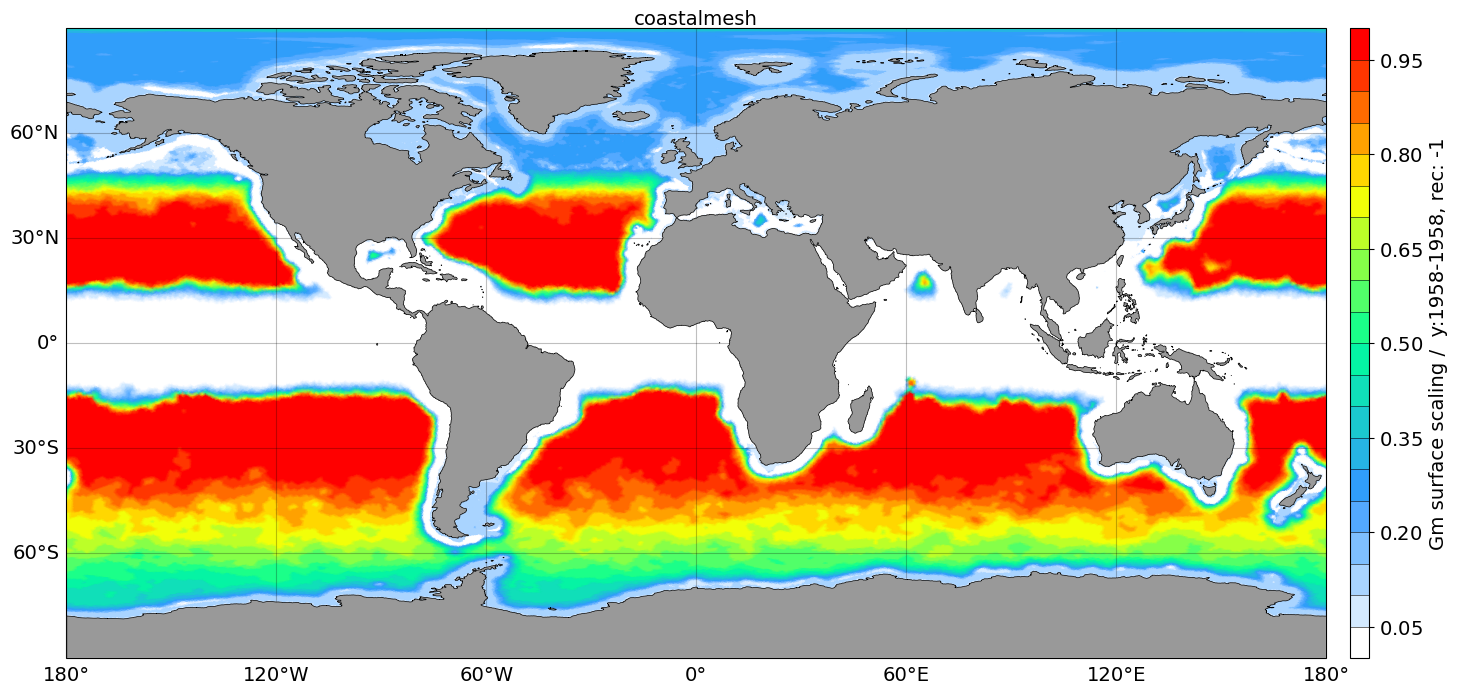

 --> elasped time to plot data: 0.21 min.


In [13]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
ts = clock.time()
ndat   = len(data_list)
if   ncol != None: 
    ncol0  = np.min([ncol,ndat])    
    nrow0  = np.ceil(ndat/ncol0).astype('int')
elif nrow != None: 
    nrow0  = np.min([nrow,ndat])    
    ncol0  = np.ceil(ndat/nrow0).astype('int')
    
idx=1 if do_clim else 0       
svname = list(data_list[idx].data_vars)[0]
slabel = data_list[idx][svname].attrs['str_lsave']

#______________________________________________________________________________________________________
# do save filename path
spath  = save_path
sfpath = None
if spath!=None: 
    sfpath=list()
    for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}.{:s}'.format(svname, proj, slabel, sfmt)) )
if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality

#______________________________________________________________________________________________________
# do colorbar either single cbar or ref_cbar + anom_cbar
if (ref_path != None) and do_reffig: cb_plt, cb_plt_single, cinfo0 = [1]+[2]*(nrow0*ncol0-1), False, [ref_cinfo.copy(), cinfo.copy()]
else: cb_plt, cb_plt_single, cinfo0 = True, True, cinfo.copy() 

#__________________________________________________________________________________________________
cinfo0.update({'cstr':'wbgyr', 'cmin':0, 'cmax':1.0})
hfig, hax, hcb = tpv.plot_hslice(mesh, data_list, cinfo=cinfo0, box=box, nrow=nrow0, ncol=ncol0, proj=proj, do_rescale=do_rescale,  
                                do_plt=do_plt, plt_contb=plt_contb, plt_contf=plt_contf, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum, 
                                ax_opt=dict({'fig_sizefac':4.0, 'cb_plt':cb_plt, 'cb_plt_single':cb_plt_single, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(),
                                do_save=sfpath, save_dpi=save_dpi) 

print(' --> elasped time to plot data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        

In [16]:
t0 = clock.time()
vname = 'temp'
depth = 50

# clean up garabage on workers before the party starts!
if client is not None: client.run(gc.collect)
    
data_list = list()
#___LOAD FESOM2 DATA___________________________________________________________
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)):
    print(ii, datapath, descript)
    ts = clock.time()
    #__________________________________________________________________________
    yeari, moni, dayi, recordi = year, mon, day, record
    if (ii==0) and (ref_path != None): yeari, moni, dayi, recordi = ref_year, ref_mon, ref_day, ref_record

    #__________________________________________________________________________
    # create shortcut for input parameter
    input_dict = dict({'year':yeari, 'mon':moni, 'day':dayi, 'record':recordi, 'depth':depth, 
                       'descript':descript, 'do_info':False, 'do_ie2n':False, 'do_rot':do_data_r2g, 
                       'chunks':chunks, 'do_parallel':do_parallel, 'do_load':True, 'do_persist':False, 
                       'client':client})
    
    data = tpv.load_data_fesom2(mesh, datapath, vname=vname, **input_dict)
    
    #__________________________________________________________________________
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    print(' --> elasped time to load {:s} data: {:3.2f} min.'.format(vname, (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))
    print('')
        
    #__________________________________________________________________________
    # create reference data if given 
    if (ii==0) and (ref_path != None):
        data_ref = data
        if do_reffig: data_list.append(data_ref) 
        continue
        
    #__________________________________________________________________________
    # compute anomaly 
    if (ref_path != None):
        data_list.append(tpv.do_anomaly(data, data_ref))  
    # compute absolute    
    else:
        data_list.append(data)  
    del(data)
    if client is not None: client.run(gc.collect)
        
if (ref_path != None): del(data_ref)
print(' --> total elasped time to process data: {:3.2f} min.'.format( (clock.time()-t0)/60  )) 

0 /albedo/scratch/user/pscholz/test_ozgures_coastalmesh_adv3rd_02/1/ coastalmesh


/albedo/home/pscholz/.conda/envs/py39_new/lib/python3.9/site-packages/xarray/core/dataset.py:277: UserWarning: The specified chunks separate the stored chunks along dimension "nz1" starting at index 5. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


 --> elasped time to load temp data: 0.05 min.
 --> data uses 0.02 Gb:

 --> total elasped time to process data: 0.05 min.


--> cmin/cmax: norm: 21.608481/29.454361, hist: 24.523226/29.230753, fin: 24.523226/29.230753
{'cstr': 'blue2red', 'cnum': 15, 'chist': True, 'ctresh': 0.995, 'cnlab': 8, 'cmin': np.float64(24.52), 'cmax': np.float64(29.23), 'cref': np.float64(27.0), 'cmap': <matplotlib.colors.ListedColormap object at 0x154e7b2edc70>, 'clevel': array([24.5 , 24.75, 25.  , 25.25, 25.5 , 25.75, 26.  , 26.25, 26.5 ,
       26.75, 27.  , 27.25, 27.5 , 27.75, 28.  , 28.25, 28.5 , 28.75,
       29.  , 29.25]), 'clab': array([24.75, 25.5 , 26.25, 27.  , 27.75, 28.5 , 29.25])}
 --> plot bot    chunk:0|
 --> plot data   chunk:0|
 > save figure: /albedo/home/pscholz/tripyview/Results/ozgures/coastalmesh/temp_pc_y1958-1958_rec_-1_dep50m.png


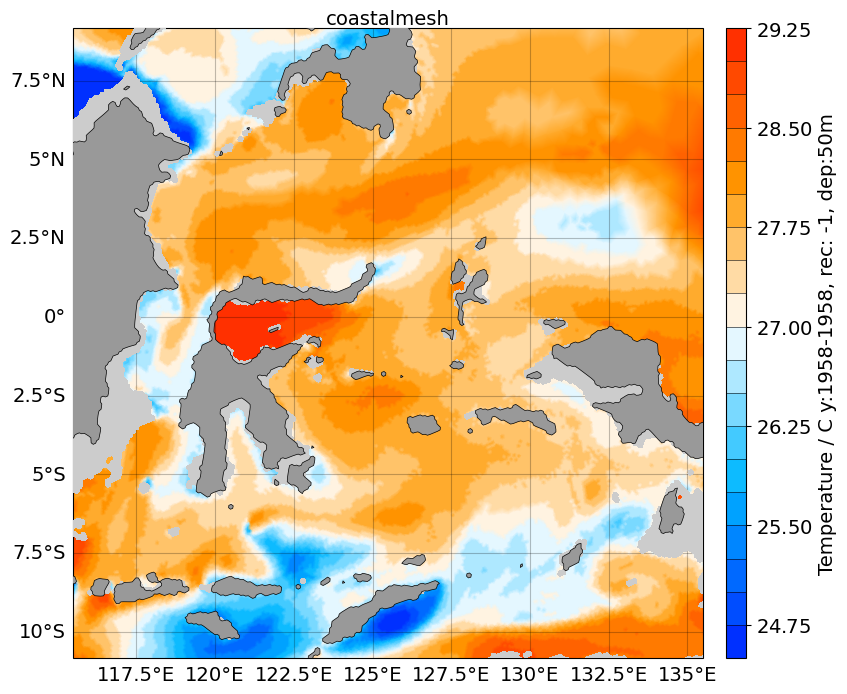

 --> elasped time to plot data: 0.04 min.


In [18]:
box_c = [125.48, -0.835]
box_w = 20
box   = [box_c[0]-box_w/2, box_c[0]+box_w/2, box_c[1]-box_w/2, box_c[1]+box_w/2]


#___PLOT FESOM2 DATA___________________________________________________________________________________
ts = clock.time()
ndat   = len(data_list)
if   ncol != None: 
    ncol0  = np.min([ncol,ndat])    
    nrow0  = np.ceil(ndat/ncol0).astype('int')
elif nrow != None: 
    nrow0  = np.min([nrow,ndat])    
    ncol0  = np.ceil(ndat/nrow0).astype('int')
    
idx=1 if do_clim else 0       
svname = list(data_list[idx].data_vars)[0]
slabel = data_list[idx][svname].attrs['str_lsave']

#______________________________________________________________________________________________________
# do save filename path
spath  = save_path
sfpath = None
if spath!=None: 
    sfpath=list()
    for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}.{:s}'.format(svname, proj, slabel, sfmt)) )
if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality

#______________________________________________________________________________________________________
# do colorbar either single cbar or ref_cbar + anom_cbar
if (ref_path != None) and do_reffig: cb_plt, cb_plt_single, cinfo0 = [1]+[2]*(nrow0*ncol0-1), False, [ref_cinfo.copy(), cinfo.copy()]
else: cb_plt, cb_plt_single, cinfo0 = True, True, cinfo.copy() 

#__________________________________________________________________________________________________

hfig, hax, hcb = tpv.plot_hslice(mesh, data_list, cinfo=cinfo0, box=box, nrow=nrow0, ncol=ncol0, proj=proj, do_rescale=do_rescale,  
                                do_plt=do_plt, plt_contb=plt_contb, plt_contf=plt_contf, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum, 
                                ax_opt=dict({'fig_sizefac':4.0, 'cb_plt':cb_plt, 'cb_plt_single':cb_plt_single, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(),
                                do_save=sfpath, save_dpi=save_dpi) 

print(' --> elasped time to plot data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        

In [37]:
t0 = clock.time()
vname = 'norm+u+v'
vname = 'w'
# vname = 'norm+tx_sur+ty_sur'
depth = 100

# clean up garabage on workers before the party starts!
if client is not None: client.run(gc.collect)
    
data_list = list()
#___LOAD FESOM2 DATA___________________________________________________________
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)):
    print(ii, datapath, descript)
    ts = clock.time()
    #__________________________________________________________________________
    yeari, moni, dayi, recordi = year, mon, day, record
    if (ii==0) and (ref_path != None): yeari, moni, dayi, recordi = ref_year, ref_mon, ref_day, ref_record

    #__________________________________________________________________________
    # create shortcut for input parameter
    input_dict = dict({'year':yeari, 'mon':moni, 'day':dayi, 'record':recordi, 'depth':depth, 
                       'descript':descript, 'do_info':False, 'do_ie2n':False, 'do_rot':do_data_r2g, 
                       'chunks':chunks, 'do_parallel':do_parallel, 'do_load':True, 'do_persist':False, 
                       'client':client})
    
    data = tpv.load_data_fesom2(mesh, datapath, vname=vname, do_file='blowup', **input_dict)
    
    #__________________________________________________________________________
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    print(' --> elasped time to load {:s} data: {:3.2f} min.'.format(vname, (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))
    print('')
        
    #__________________________________________________________________________
    # create reference data if given 
    if (ii==0) and (ref_path != None):
        data_ref = data
        if do_reffig: data_list.append(data_ref) 
        continue
        
    #__________________________________________________________________________
    # compute anomaly 
    if (ref_path != None):
        data_list.append(tpv.do_anomaly(data, data_ref))  
    # compute absolute    
    else:
        data_list.append(data)  
    del(data)
    if client is not None: client.run(gc.collect)
        
if (ref_path != None): del(data_ref)
print(' --> total elasped time to process data: {:3.2f} min.'.format( (clock.time()-t0)/60  )) 

0 /albedo/scratch/user/pscholz/test_ozgures_coastalmesh_adv3rd_02/1/ coastalmesh
['/albedo/scratch/user/pscholz/test_ozgures_coastalmesh_adv3rd_02/1/fesom.1958.oce.blowup.nc']


/albedo/home/pscholz/.conda/envs/py39_new/lib/python3.9/site-packages/xarray/core/dataset.py:277: UserWarning: The specified chunks separate the stored chunks along dimension "nz" starting at index 5. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


 > var in file: ['iter', 'eta_n', 'hbar', 'd_eta', 'ssh_rhs', 'ssh_rhs_old', 'hnode', 'helem', 'u', 'v', 'u_rhs', 'v_rhs', 'urhs_AB', 'vrhs_AB', 'zbar_n_bot', 'zbar_e_bot', 'bottom_node_thickness', 'bottom_elem_thickness', 'temp', 'salt', 'w', 'w_expl', 'w_impl', 'cfl_z', 'a_ice', 'm_ice', 'm_snow', 'u_ice', 'v_ice', 'heat_flux', 'water_flux', 'tx_sur', 'ty_sur', 'Kv', 'Av', 'N2']
 --> elasped time to load w data: 0.05 min.
 --> data uses 0.02 Gb:

 --> total elasped time to process data: 0.05 min.


--> cmin/cmax: norm: -1061.885130/1613.885384, hist: -3.617892/-0.942121, fin: -3.617892/-0.942121
{'cstr': 'blue2red', 'cnum': 15, 'chist': True, 'ctresh': 0.995, 'cref': np.int64(0), 'cnlab': 8, 'cmin': np.float64(-3.62), 'cmax': np.float32(1.1920929e-07), 'cmap': <matplotlib.colors.ListedColormap object at 0x1550766099a0>, 'clevel': array([-3.8, -3.6, -3.4, -3.2, -3. , -2.8, -2.6, -2.4, -2.2, -2. , -1.8,
       -1.6, -1.4, -1.2, -1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2]), 'clab': array([-3.6, -3. , -2.4, -1.8, -1.2, -0.6,  0. ])}
 --> plot bot    chunk:0|
 --> plot data   chunk:0|
 > save figure: /albedo/home/pscholz/tripyview/Results/ozgures/coastalmesh/w_pc_y1958-1958_rec_-1_dep100m.png


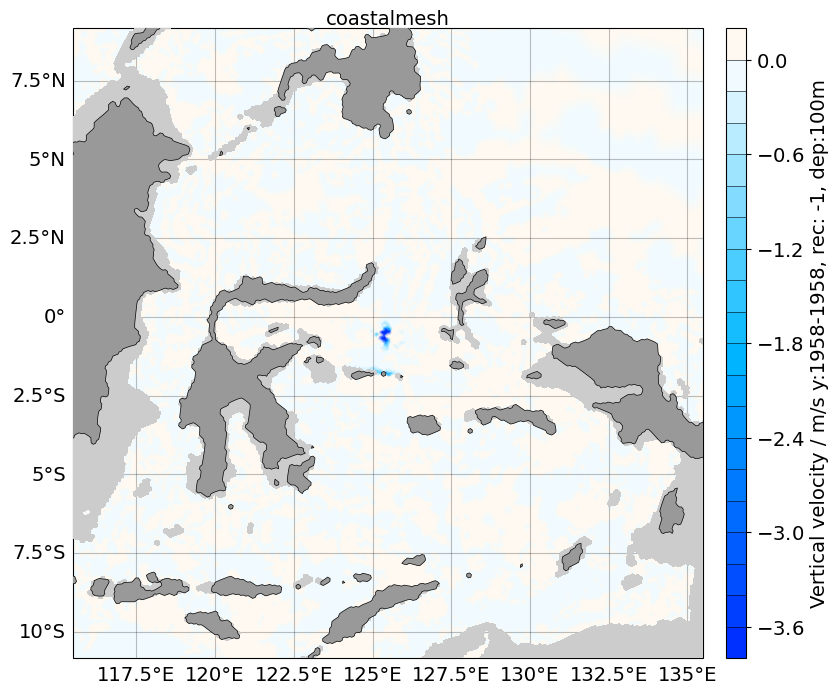

 --> elasped time to plot data: 0.04 min.


In [38]:
box_c = [125.48, -0.835]
box_w = 20
box   = [box_c[0]-box_w/2, box_c[0]+box_w/2, box_c[1]-box_w/2, box_c[1]+box_w/2]


#___PLOT FESOM2 DATA___________________________________________________________________________________
ts = clock.time()
ndat   = len(data_list)
if   ncol != None: 
    ncol0  = np.min([ncol,ndat])    
    nrow0  = np.ceil(ndat/ncol0).astype('int')
elif nrow != None: 
    nrow0  = np.min([nrow,ndat])    
    ncol0  = np.ceil(ndat/nrow0).astype('int')
    
idx=1 if do_clim else 0       
svname = list(data_list[idx].data_vars)[0]
slabel = data_list[idx][svname].attrs['str_lsave']

#______________________________________________________________________________________________________
# do save filename path
spath  = save_path
sfpath = None
if spath!=None: 
    sfpath=list()
    for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}.{:s}'.format(svname, proj, slabel, sfmt)) )
if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality

#______________________________________________________________________________________________________
# do colorbar either single cbar or ref_cbar + anom_cbar
if (ref_path != None) and do_reffig: cb_plt, cb_plt_single, cinfo0 = [1]+[2]*(nrow0*ncol0-1), False, [ref_cinfo.copy(), cinfo.copy()]
else: cb_plt, cb_plt_single, cinfo0 = True, True, cinfo.copy() 

#__________________________________________________________________________________________________
cinfo0.update({'cref':0})

hfig, hax, hcb = tpv.plot_hslice(mesh, data_list, cinfo=cinfo0, box=box, nrow=nrow0, ncol=ncol0, proj=proj, do_rescale=do_rescale,  
                                do_plt=do_plt, plt_contb=plt_contb, plt_contf=plt_contf, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum, 
                                ax_opt=dict({'fig_sizefac':4.0, 'cb_plt':cb_plt, 'cb_plt_single':cb_plt_single, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(),
                                do_save=sfpath, save_dpi=save_dpi) 

print(' --> elasped time to plot data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        

In [7]:
if do_papermill and do_parallel and client is not None: client.shutdown()